## Topic Modelling 1 - 1000 samples

### Before you begin
We will be using the gensim and nltk libraries in this notebook.  
Gensim does not work well with Python > 3.11, so create a separate virtual environment (venv) with Python 3.11 if you have a more recent Python version. You'll also need numpy, pandas and Jupyter notebook in this venv. 

It is easiest to create and activate a venv with the above libraries in Anaconda Navigator, if you're using Anaconda. However, the default version in Anaconda of a gensim dependency, scipy, is version 1.15, which is not compatible with gensim. Using pip in a terminal, install scipy < 1.14 instead. For those of you who are setting up virtual environments, the requirements.txt file can be found at https://github.com/eukairos/topic-models.    

Also note that some of the cells in this notebook may take some time to run, because some operations are computationally intensive.


In [60]:
# ! pip install gensim, nltk
# nltk.download()
# uncomment the above if you need to install gensim and nltk. The nltk libraries take a while to download. 
# you can monitor progress in the separate window nltk opens (look in your taskbar for a new icon that will appear), or go make a cup of coffee


### Steps in topic modelling

In this project, we will extract topics from a sample dataset of 1000 pubmed abstracts using the classical 'bag-of-words' approach. 

The steps involved are:-
1. Pre-process/normalize the data.
2. Create multi-word tokens (in our case, bigrams) to serve as data feedstock for the topic model.
3. Compile a dictionary from our bigrams.
4. Compile a corpus
5. Train our topic model from the corpus.
6. Visualize and evaluate our results

Let's go!

### Dataset

Download the csv file at this location: https://huggingface.co/datasets/owaiskha9654/PubMed_MultiLabel_Text_Classification_Dataset_MeSH into your current working directory. This dataset is released under academic free license - many thanks to Huggingface user owaiskha9564



In [1]:
import pandas as pd
data = pd.read_csv('topic_model_pubmed.csv') # I renamed the file...
data.columns

Index(['Title', 'abstractText', 'meshMajor', 'pmid', 'meshid', 'meshroot', 'A',
       'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z'],
      dtype='str')

In [2]:
# let's survey the dataset
data.head()

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,1,0,0,1,0,0,0,0,0,0
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,1,1,1,0,1,1,0,1,1,1
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,1,0,1,0,0,0,1,0,0,0
3,Multilayer capsules: a promising microencapsul...,"In 1980, Lim and Sun introduced a microcapsule...","['Acrylic Resins', 'Alginates', 'Animals', 'Bi...",11426874,"[['D05.750.716.822.111', 'D25.720.716.822.111'...","['Chemicals and Drugs [D]', 'Technology, Indus...",1,1,1,1,1,0,1,0,0,1,0,0,0,0
4,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr...",Substantially improved hydrogel particles base...,"['Antineoplastic Agents', 'Cell Proliferation'...",28323099,"[['D27.505.954.248'], ['G04.161.750', 'G07.345...","['Chemicals and Drugs [D]', 'Phenomena and Pro...",1,1,0,1,1,0,1,0,0,1,0,0,0,0


the columns A - Z are one-hot encodings of class labels. We won't be making use of them for this notebook. You can remove them if you like. But they tell us that there are at least 14 topics in this dataset. The actual class labels are found in the meshroot column. The meshMajor terms could have been used as possible topics, but unfortunately there are about 11000 MESH terms here, which is too many for us to study.  

In [3]:
data['meshMajor'][0]

"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'Humans', 'Immunohistochemistry', 'Papillomaviridae', 'Tumor Suppressor Protein p53', 'Uterine Cervical Dysplasia', 'Uterine Cervical Neoplasms']"

In [4]:
# this cell extracts the classes from meshroot column, no need to run this

import ast
from itertools import chain

def extract_classes(series):
    def string_to_list(a_string):  # meshroot entries are strings, we convert them to lists first.
        raw = ast.literal_eval(f'[{a_string}]') 
        # reference here: https://www.reddit.com/r/learnpython/comments/psjqrd/what_are_the_uses_of_the_ast_module_in_python/
        return raw
    return series.apply(string_to_list)

raw_topics = extract_classes(data['meshroot'])

topics = []

for n in range(1,100):  # this should be enough to catch all the meshroot classes
    raw_list = raw_topics[n]
    topics.extend(raw_list)

topics_list = list(set(chain.from_iterable(topics))) # flatten to a single list, then create a set of unique meshroot classes
sorted_topics_list = sorted(topics_list, key=lambda x: x[x.rfind('[')+1]) # sort by the character following an opening parenthesis
sorted_topics_list

['Anatomy [A]',
 'Organisms [B]',
 'Diseases [C]',
 'Chemicals and Drugs [D]',
 'Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]',
 'Psychiatry and Psychology [F]',
 'Phenomena and Processes [G]',
 'Disciplines and Occupations [H]',
 'Anthropology, Education, Sociology, and Social Phenomena [I]',
 'Technology, Industry, and Agriculture [J]',
 'Humanities [K]',
 'Information Science [L]',
 'Named Groups [M]',
 'Health Care [N]',
 'Geographicals [Z]']

In [5]:
# dropping unwanted columns

to_drop = ['Title','pmid','meshMajor', 'meshid', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']
data = data.drop(to_drop, axis=1)

# taking a sample
data = data.sample(n=1000, random_state=42)

# reseting the index
data = data.reset_index(drop=True)

data

,abstractText,meshroot
0,We reviewed the patterns of injuries sustained...,"['Health Care [N]', 'Named Groups [M]', 'Organ..."
1,The effect of orthodontic-surgical treatment o...,"['Named Groups [M]', 'Anatomy [A]', 'Analytica..."
2,Sciatic nerves of 25-week-old genetically diab...,"['Organisms [B]', 'Chemicals and Drugs [D]', '..."
3,Effects of temperature on development of Raja ...,"['Phenomena and Processes [G]', 'Analytical, D..."
4,The aim of this study was to obtain MR images ...,"['Named Groups [M]', 'Analytical, Diagnostic a..."
...,...,...
995,Temporary division of the superior vena cava a...,"['Organisms [B]', 'Anatomy [A]', 'Analytical, ..."
996,In the process of establishing the specificity...,"['Chemicals and Drugs [D]', 'Organisms [B]', '..."
997,This paper presents the results of a research ...,"['Chemicals and Drugs [D]', 'Analytical, Diagn..."
998,Cancer has been the leading cause of death in ...,"['Named Groups [M]', 'Health Care [N]', 'Disci..."


In [6]:
# get a feel of the abstracts

def get_all_lengths(series):
    def get_abs_length(abstract):
        return(len(abstract))
    return series.apply(get_abs_length)

abstracts_length = get_all_lengths(data['abstractText'])

longest = max(abstracts_length)
shortest = min(abstracts_length)

print(longest, shortest)


3755 156


### Pre-processing/Normalization

In [7]:
# First convert text to lowercase. Case is not required for our purposes.

data['abstractText'] = data['abstractText'].str.lower()
print(data['abstractText'][:3])

0    we reviewed the patterns of injuries sustained...
1    the effect of orthodontic-surgical treatment o...
2    sciatic nerves of 25-week-old genetically diab...
Name: abstractText, dtype: str


#### Stopwords

Stopwords are common words that typically do not carry significant meaning on their own and can be considered noise in the context of many NLP applications. Common stopwords are articles (a, an, the), prepositions (in, on, at, by), conjunctions (and, but), pronouns (i, you, we, he, she), verbs (is, are, was, were).  
Gensim provides a list of stopwords, and you can also customize stopwords like so:

In [8]:
# Customise stopwords

import gensim
from gensim.parsing.preprocessing import STOPWORDS

# import a list of pubmed stopwords; put this file into your working directory.
pubstop = pd.read_csv('pubmed_stopwords.csv')
print(pubstop)
pubmed_stopwords = pubstop['stopwords'].to_list()

# create set of stopwords
custom_stopwords = set(STOPWORDS)
# add new stopwords
custom_stopwords.update(pubmed_stopwords)
# remove words from set (ie you want to keep the word)
# custom.stopwords.discard('not')


            stopwords
0         background:
1       introduction:
2          objective:
3         objectives:
4            purpose:
5           purposes:
6             method:
7            methods:
8            results:
9         conclusion:
10              study
11      observational
12    cross-sectional
13            disease
14            patient
15           patients
16           research
17          treatment
18            disease
19               year
20               case
21              group
22       case-control
23            studies
24             cohort
25        prospective
26      retrospective
27         ecological
28       case reports
29        case series
30          pragmatic
31         randomized
32                rct
33  systematic review
34      meta-analysis
35        qualitative
36               data
37                  p
38                  n
39                 n=
40                  s
41                  h
42                  t
43                  k
44        

Since Pubmed is essentially a collection of studies, many abstracts will refer to themselves eg "in the present study", "this is a cross-sectional study". If we don't remove these, "studies" might turn up as a very prevalent topic. Similarly, many abstracts have headers such as 'background', 'objective', 'methods', 'results' and 'conclusion'. These are going to pop up very often. We can remove these as topic modelling is a vector space model that relies on a 'bag-of-words' approach. If I were using a language model for another NLP purpose, I might opt to retain the headers as they do provide some context information.

In [9]:
# renove stopwords

def remove_stopwords(series):
    def clean_text(text):
        # split words
        words = text.split()
        # filter stopwords
        filtered = [word for word in words if word not in custom_stopwords]
        return ' '.join(filtered)
    return series.apply(clean_text)

In [10]:
data['abstractText_no_stopwords'] = remove_stopwords(data['abstractText'])
data['abstractText_no_stopwords'][:5]

0    reviewed patterns injuries sustained 12 consec...
1    effect orthodontic-surgical submental-cervical...
2    sciatic nerves 25-week-old genetically diabeti...
3    effects temperature development raja microocel...
4    aim obtain mr images flexed-knee position comp...
Name: abstractText_no_stopwords, dtype: str

#### Remove numerals
Numbers are common in the results sections of abstracts, but they do not add meaningfully to topic discovery. We'll remove them.

In [11]:
import re # this is the native Python regex module

def remove_numbers(series):
    def rem_no(text):
        pattern = r'\b\d+(\.\d{1,2})?\b'
        cleaned_text = re.sub(pattern, '', text)
        cleaned_text = cleaned_text.strip()
        return cleaned_text
    return series.apply(rem_no)


In [12]:
data['abstractText_no_numbers'] = remove_numbers(data['abstractText_no_stopwords'])

#### Tokenization

Tokenization is a wide topic, but here we'll only look at word tokenization. For topic modelling purposes, it just means breaking down text into individual words, because all we want is just a collection of words in a collection of documents.


In [13]:
# Next, tokenize the text into individual words

from nltk.tokenize import word_tokenize

def tokenize_series(text_series: pd.Series) -> pd.Series:
    tokenize = lambda text: word_tokenize(text)
    return text_series.apply(tokenize)

In [14]:
data['abstract_tokens'] = tokenize_series(data['abstractText_no_numbers'])

In [15]:
data['abstract_tokens'][5:10]

5    [objectives, develop, rapid, calf-side, test, ...
6    [systemic, sclerosis, (, ssc, ), presents, sti...
7    [competitive, polymerase, chain, reaction, qua...
8    [coordinating, care, terminally, ill, children...
9    [sleep-disordered, breathing, (, sdb, ), commo...
Name: abstract_tokens, dtype: object

In [16]:
# remove punctuation

import string

def no_punct(series):
    def remove_punct(word_list):
        return [word for word in word_list if word not in string.punctuation]
    return series.apply(remove_punct)
        

In [17]:
data['abstract_no_punct'] = no_punct(data['abstract_tokens'])

In [18]:
data.head()

,abstractText,meshroot,abstractText_no_stopwords,abstractText_no_numbers,abstract_tokens,abstract_no_punct
0,we reviewed the patterns of injuries sustained...,"['Health Care [N]', 'Named Groups [M]', 'Organ...",reviewed patterns injuries sustained 12 consec...,reviewed patterns injuries sustained consecut...,"[reviewed, patterns, injuries, sustained, cons...","[reviewed, patterns, injuries, sustained, cons..."
1,the effect of orthodontic-surgical treatment o...,"['Named Groups [M]', 'Anatomy [A]', 'Analytica...",effect orthodontic-surgical submental-cervical...,effect orthodontic-surgical submental-cervical...,"[effect, orthodontic-surgical, submental-cervi...","[effect, orthodontic-surgical, submental-cervi..."
2,sciatic nerves of 25-week-old genetically diab...,"['Organisms [B]', 'Chemicals and Drugs [D]', '...",sciatic nerves 25-week-old genetically diabeti...,sciatic nerves -week-old genetically diabetic ...,"[sciatic, nerves, -week-old, genetically, diab...","[sciatic, nerves, -week-old, genetically, diab..."
3,effects of temperature on development of raja ...,"['Phenomena and Processes [G]', 'Analytical, D...",effects temperature development raja microocel...,effects temperature development raja microocel...,"[effects, temperature, development, raja, micr...","[effects, temperature, development, raja, micr..."
4,the aim of this study was to obtain mr images ...,"['Named Groups [M]', 'Analytical, Diagnostic a...",aim obtain mr images flexed-knee position comp...,aim obtain mr images flexed-knee position comp...,"[aim, obtain, mr, images, flexed-knee, positio...","[aim, obtain, mr, images, flexed-knee, positio..."


As you can see, the abstract_tokens column does not hold strings, it holds lists of words. We'll need to handle subsequent processing as lists, instead of strings. Punctuation does not remove hyphens linking words eg "high-dose".

 #### Stemming and Lemmatization

Stemming involves reducing a word to its base or root form by removing prefixes, suffixes or other word endings. For example, the stem of 'running' and 'ran' would be 'run'.  
Lemmatization is rather more sophisticated than stemming: it considers the context and meaning of the word. For example, the lemma of 'running' is 'run', but the lemma of 'lovely' is not necessarily 'love' but it could be - the context matters.  The lemma of 'better' and 'best' would be 'good', wouldn't it?  
Lemmatization is more accurate than stemming, but is also more computationally intensive and thus slower.

Both stemming and lemmatization serve to improve accuracy of downstream NLP by reducing words to their base forms. You usually select one or the other, depending on your use case. For use cases where speed is more important than accuracy, you might opt to do stemming instead of lemmatization, otherwise lemmatization is usually preferred.

In the cell below, we use nltk's lemmatizer which leverages WordNet, and is widely considered to be one of the more accurate lemmatizers.

WordNet (https://wordnet.princeton.edu/) is a large lexical database that groups words into sets of synonyms (called synsets) and records semantic relationships between these words. It is a valuable open-source resource for various NLP tasks. In the example below, WordNet helps more accurate lemmatization by identifying the part-of-speech which a word resides in.

In [19]:
# lemmatize 

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def lemmatize_words(series: pd.Series) -> pd.Series:
    """
    Lemmatizes words in a pandas Series where each element is a list of words, using NLTK.
    Improves lemmatization by using POS (Part-of-Speech) tagging.
    """
    def get_wordnet_pos(word):
        """
        Maps a word's Penn Treebank POS tag to a WordNet POS tag. (Penn Treebank POS is nltk's internal word tagging)
        This is needed for accurate lemmatization with NLTK.
        """
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)  # Default to NOUN if no match

    def lemmatize_list(word_list):
        """Lemmatizes a single list of words using NLTK and POS tagging."""
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_list]

    return series.apply(lemmatize_list)
        

The following cell will take a while, lemmatization is computationally intensive. It took about 20min on my PC. YMML.

In [20]:
data['lemmas'] = lemmatize_words(data['abstract_no_punct'])
data['lemmas'][5:10]

5    [objective, develop, rapid, calf-side, test, d...
6    [systemic, sclerosis, ssc, present, stiffness,...
7    [competitive, polymerase, chain, reaction, qua...
8    [coordinate, care, terminally, ill, child, dif...
9    [sleep-disordered, breathing, sdb, common, end...
Name: lemmas, dtype: object

If you compare the ['lemmas'] column to the ['abstract_tokens'] column, you can see that, for example, 'continues' was lemmatized to 'continue' but 'disproportionately' was not lemmatized.

#### Preprocessing/normalization summary

Collectively, converting to lower case, removing stopwords and punctuation, tokenization, stemming and lemmatization (and some other preprocessing steps that we did not cover here, such as handling special characters and accents) serve to render various text data from different sources into a standard format to ensure consistency and reduce variability. We refer to this as "**normalization**" of text data. Note that this meaning is different from what you may have learnt about normalization in database courses (like 1st normal form, 2nd normal form) and in statistics (min-max scaling, z-score standardization etc...). The stem is the same, but the lemma is not; again - the context matters.

#### Assignment
Using just native Python modules (try using string and unicode), write functions to:  
1. remove special characters, and
2. remove accents.

#### N-Grams

N-grams refer to contiguous items in a given text. They are used in a wide variety of NLP tasks, including topic modelling. If the items are word tokens, unigrams are single words, bigrams are 2 words. So 'quick' is a unigram, 'quick brown' and 'brown fox' are bigrams. Triplets of consecutive items are trigrams. From the same text, you'll usually generate overlapping n-grams to feed into the topic model. The higher the 'n', the more information can be derived, at higher computational cost. For example 'machine learning' has a different meaning from 'machine' and 'learning'.  Typically, libraries will generate overlapping n-grams like 'quick brown' and 'brown fox' in order to capture semantic meanings more fully. But it doesn't necessarily hold that the higher n you use, the more accurate the results of your modelling.

So, what is the ideal 'n'? It depends on your text. For short texts like the abstracts we're reading here, unigrams might well suffice. But then again, medical jargon is full of multi-grams (think 'Type IV renal tubular acidosis' or 'percutaneous endoscopic gastrostomy tube placement'). For our exploration purposes in this notebook, we'll work with unigrams and bigrams.

In [21]:
# compute bigrams

from gensim.models import Phrases # the Phrases method automatically detects common phrases

# function to make bigrams
def compute_bigram(series, min_count, threshold):
    bigram_model = Phrases(series.to_list(), min_count = min_count, threshold = threshold)
    # to_list() converts the pandas column to a list, because Phrases works with lists.

    # to make trigrams, just repeat the function! similarly for quadrigrams, pentagrams etc....
    # trigram_model = Phrases(bigram_model, min_count=min_count, threshold=threshold)
    
    def apply_phrases(unigram_list):
        return bigram_model[unigram_list]

    return series.apply(apply_phrases)


In [22]:
min_count = 5
threshold = 10

data['bigrams'] = compute_bigram(data['lemmas'], min_count=min_count, threshold = threshold)

In [23]:
data['bigrams'][50:80]

50    [trial, conduct, effect, feed, mixture, ammoni...
51    [numerous, hallux, proximal, phalanx, osteotom...
52    [transcriptional, epigenetic, regulation, fund...
53    [evaluate, factor_associate, frequency, house,...
54    [new, specie, rhinolophus, philippinensis, chi...
55    [described, multiple, benign, chondromatous, i...
56    [histological, examination, nissl, golgi, stai...
57    [article, author, consider, opportunity, learn...
58    [production, purification, detoxification, cho...
59    [structure, chemical, nature, serologically, d...
60    [osteopontin, osteoblast-secreted, protein, as...
61    [compound, ly253963, ,-thiadiazol, --, ylcyana...
62    [cytoskeletal, actin, regulate, part, rho, rho...
63    [understand, control, mechanism_underlie, gast...
64    [establish, expression, full-length, hiv-, tra...
65    [x, gx, phospholipase, a, member, large, secre...
66    [background/purpose, rapid, progress, biotechn...
67    [constitutive, endothelial, isoform, nitri

Bigrams are linked with underscores. You can see that we now have 'g_protein' and 'e._coli' in the text. Bigrams add further semantic richness to the dataset.

The 'min_count' and 'threshold' variables are what we might call hyperparameters. Gensim refers to them as parameters, but they behave like hyperparameters (you should have encountered both parameters and hyperparameters in the deep learning module in this course). The model can't learn their optimal values, and you'll need to adjust them if your results aren't to your liking. Here, I have set a min_count of 5; this means that Phrases will collect bigrams which occur 5 times or more in each abstract (it is each abstract, and not whole dataset, because the bigram_model function is applied iteratively on each row of the ['lemmas'] column). The threshold hyperparameter refers to an internal gensim scoring system - you can read the documentation here: https://radimrehurek.com/gensim/models/phrases.html. A higher threshold will result in fewer phrases generated.  
What are principles and considerations for selecting min_count and threshold values? In general, the larger the corpus, the higher the threshold. For medical texts, n-grams occur frequently (eg 'blood pressure') enough that we might be comfortable setting a higher threshold. But some experimentation is inevitable.

We can also inspect the tokens. 

In [24]:
sample = list(data['bigrams'][1]) 
sample


['effect',
 'orthodontic-surgical',
 'submental-cervical',
 'region',
 'evaluate',
 'limited',
 'number',
 'study',
 'aim_evaluate',
 'submental-cervical',
 'soft_tissue',
 'contour',
 'change',
 'follow',
 'mandibular',
 'advancement',
 'set-back',
 'procedure',
 'bilateral',
 'sagittal',
 'split',
 'ramus',
 'osteotomy',
 'sixty-seven',
 'include',
 'study',
 'consist',
 'skeletal',
 'class_ii',
 'underwent',
 'mandibular',
 'advancement',
 'surgery',
 'consist',
 'skeletal',
 'class',
 'iii',
 'underwent',
 'mandibular',
 'set-back',
 'surgery',
 'linear',
 'angular',
 'measurement',
 'perform',
 'pre-operative',
 'sixth',
 'month',
 'post-operative',
 'cephalometric',
 'radiograph',
 'new_method',
 'evaluate',
 'sag',
 'submental',
 'region',
 'submental',
 'length',
 'change',
 'however',
 'decrease',
 'significantly',
 'p_·',
 'angle',
 'submental',
 'plane',
 'facial',
 'plane',
 'decrease',
 '·°',
 '·°',
 'p_·',
 'increase',
 '·°',
 '·°',
 'group2',
 'p_·',
 'change',
 'subment

### Build the dictionary and training corpus

In [25]:
# Adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ 
# and https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

from gensim.corpora import Dictionary

# Create a dictionary representation of the documents
id2word = Dictionary(data['bigrams'])

# filter out rare words and extremely common words
id2word.filter_extremes(no_below = 5, no_above = 0.95)

We might want to remove rare words and extremely common words (ie they behave like stopwords) like we would remove outliers when cleaning structured data. 'Rare' and 'common' in this context means across documents, not within documents. The hyperparameter 'no_below' and 'no_above' means that we want to remove words occuring in less than 5 documents and in more than 95% of documents. Again, these are not learnable by the model, you'll have to adjust these.  Depending on your use case and the size of your dataset, you might not want to filter rare, common, or both. If your dataset is small, for example, you would prefer to keep as many tokens as possible available for training. If you're trying to identify instances of a rare disease in a large corpus (one that doesn't get coded into structured data, which is why you're using topic modelling in the first place), you would not want to filter 'no_below'.

In [26]:
# create corpus

texts = data['bigrams']

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 2), (10, 1), (11, 4), (12, 1), (13, 1), (14, 2), (15, 2), (16, 1), (17, 3), (18, 1), (19, 6), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1)]]


Under the hood, gensim creates a unique id for each word in each document. The result is a Dictionary object. The id is the first number in each tuple in the sample above - you can see it's a running number. 

Using the dictionary as input, the 'doctobow' method then counts the occurrences of each token - this is the second number in each tuple above. This representation, known as a 'bag-of-words', is used by our topic model.

In [27]:
# to see which id maps to which word:
id2word[10]

'force'

In [28]:
# this is a more readable view
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('bladder', 1),
  ('chronic', 1),
  ('common', 1),
  ('consecutive', 1),
  ('die', 1),
  ('disability', 1),
  ('extremity', 1),
  ('fall', 2),
  ('fell', 1),
  ('foot', 2),
  ('force', 1),
  ('fracture', 4),
  ('frequent', 1),
  ('great', 1),
  ('height', 2),
  ('impact', 2),
  ('important', 1),
  ('include', 3),
  ('initial', 1),
  ('injury', 6),
  ('internal', 1),
  ('morbidity', 1),
  ('organ', 1),
  ('patient', 1),
  ('pattern', 1),
  ('possible', 1),
  ('primary', 1),
  ('prolong', 1),
  ('range', 1),
  ('recognize', 1),
  ('renal', 1),
  ('result', 2),
  ('review', 1),
  ('risk', 1),
  ('secondary', 1),
  ('significant', 1),
  ('skeletal', 2),
  ('stabilization', 1),
  ('survival', 1),
  ('survive', 1),
  ('sustain', 2),
  ('thoracic', 1),
  ('tract', 1),
  ('upper', 1)]]

In [29]:
# Let's see how many tokens and documents we have

print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2829
Number of documents: 1000


### Training our Topic Model

We will use Latent Dirichlet Allocation. This may take quite a while. 

In [30]:
# LDA model
# the API reference here: https://radimrehurek.com/gensim/models/ldamodel.html

import gensim
import logging

# turning on logging enables us to monitor training progress. We want to see that training eventually converges.
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.NOTSET)


In [31]:
num_topics = 20
chunksize = 500
passes = 10
iterations = 20
update_every = 1
eval_every = 5
random_state = 42

lda_model = gensim.models.ldamodel.LdaModel(
    corpus = corpus,
    id2word = id2word,
    num_topics = num_topics, 
    random_state = random_state,
    update_every = update_every,
    eval_every = eval_every,
    chunksize = chunksize,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    per_word_topics=True)


2026-02-03 19:01:44,320 : INFO : using autotuned alpha, starting with [np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05), np.float32(0.05)]
2026-02-03 19:01:44,320 : INFO : using serial LDA version on this node
2026-02-03 19:01:44,326 : INFO : running online (multi-pass) LDA training, 20 topics, 10 passes over the supplied corpus of 1000 documents, updating model once every 500 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2026-02-03 19:01:44,326 : INFO : PROGRESS: pass 0, at document #500/1000
2026-02-03 19:01:44,326 : DEBUG : performing inference on a chunk of 500 documents
2026-02-03 19:01:44,447 : DEBUG : 51/500 documents converged w

There's a lot to unpack in the hyperparameters. You can read the documentation in the link provided for what the hyperparameters do. Again, there's quite a bit of experimentation to optimize the hyperparameters.  
While dataset owner has pre-identified 14 topics for us here, that's usually not going to be the case for your future projects. You'll have to make a judgment on how many topics is optimum. This will often depend on your appreciation of the dataset and the domain knowledge of your domain experts.

In [32]:
# let's have a look at the topics discovered:
import pprint
pprint.pp(lda_model.print_topics(num_topics, num_words=10))
#doc_lda = lda_model[corpus]

2026-02-03 19:02:23,748 : INFO : topic #0 (0.058): 0.019*"infection" + 0.010*"cause" + 0.009*"high" + 0.007*"task" + 0.007*"type" + 0.007*"genetic" + 0.007*"isolated" + 0.007*"infant" + 0.007*"strain" + 0.006*"illness"
2026-02-03 19:02:23,748 : INFO : topic #1 (0.039): 0.019*"injury" + 0.016*"week" + 0.012*"response" + 0.011*"adult" + 0.010*"assessment" + 0.009*"high" + 0.009*"level" + 0.009*"drive" + 0.009*"cu" + 0.009*"participant"
2026-02-03 19:02:23,748 : INFO : topic #2 (0.054): 0.049*"cell" + 0.012*"increase" + 0.011*"effect" + 0.010*"expression" + 0.010*"ca2+" + 0.009*"drug" + 0.009*"lymphocyte" + 0.008*"receptor" + 0.008*"detect" + 0.008*"area"
2026-02-03 19:02:23,748 : INFO : topic #3 (0.057): 0.017*"increase" + 0.011*"level" + 0.010*"month" + 0.010*"age" + 0.009*"effect" + 0.009*"day" + 0.009*"low" + 0.008*"p" + 0.008*"exercise" + 0.008*"mean"
2026-02-03 19:02:23,748 : INFO : topic #4 (0.066): 0.010*"tumor" + 0.009*"analysis" + 0.007*"factor" + 0.006*"outcome" + 0.006*"predic

[(0,
  '0.019*"infection" + 0.010*"cause" + 0.009*"high" + 0.007*"task" + '
  '0.007*"type" + 0.007*"genetic" + 0.007*"isolated" + 0.007*"infant" + '
  '0.007*"strain" + 0.006*"illness"'),
 (1,
  '0.019*"injury" + 0.016*"week" + 0.012*"response" + 0.011*"adult" + '
  '0.010*"assessment" + 0.009*"high" + 0.009*"level" + 0.009*"drive" + '
  '0.009*"cu" + 0.009*"participant"'),
 (2,
  '0.049*"cell" + 0.012*"increase" + 0.011*"effect" + 0.010*"expression" + '
  '0.010*"ca2+" + 0.009*"drug" + 0.009*"lymphocyte" + 0.008*"receptor" + '
  '0.008*"detect" + 0.008*"area"'),
 (3,
  '0.017*"increase" + 0.011*"level" + 0.010*"month" + 0.010*"age" + '
  '0.009*"effect" + 0.009*"day" + 0.009*"low" + 0.008*"p" + 0.008*"exercise" + '
  '0.008*"mean"'),
 (4,
  '0.010*"tumor" + 0.009*"analysis" + 0.007*"factor" + 0.006*"outcome" + '
  '0.006*"predict" + 0.006*"time" + 0.006*"exposure" + 0.006*"female" + '
  '0.006*"male" + 0.006*"control"'),
 (5,
  '0.014*"f" + 0.012*"length" + 0.012*"group" + 0.011*"ves

We asked the model to print out the top 10 words contributing to each topic.The numbers preceding each word are weights that indicate the contribution of that word to the topic discovered, similar to the coefficients in regression. 

Just by eyeballing my output (yours will differ), I can make out, for instance that topic 0 is about inflammation, topic 2 is about cellular metabolism and topic 3 is about exercise. The rest are not so perceivable to me. 

Do these topics correspond roughly with the 14 meshroot classes of the original dataset which we extracted earlier, and reproduced below? Not quite. It looks like we should explore setting different numbers of topics. We'll do that later.

### Visualization

Let's visualize the model using pyLDAvis. This package works only for models built with LDA, and it has an integration module with gensim, making it easy for us to create the visualization.

In [33]:
# Adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ 

# !pip install pyLDAvis - uncomment if not installed yet

import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

2026-02-03 19:06:50,379 : DEBUG : performing inference on a chunk of 1000 documents
2026-02-03 19:06:50,474 : DEBUG : 981/1000 documents converged within 50 iterations


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.232085 -0.069144       1        1  8.778285
7     -0.120812 -0.057692       2        1  7.492968
15     0.169797  0.018316       3        1  7.042681
3     -0.077179 -0.102298       4        1  6.274969
4     -0.071599  0.095539       5        1  6.234689
16    -0.003879  0.107163       6        1  5.453377
11    -0.123207 -0.060383       7        1  5.361687
13     0.229890  0.007226       8        1  5.347452
2      0.176322 -0.045073       9        1  5.173781
14     0.060716  0.101841      10        1  5.132812
12    -0.119804  0.079608      11        1  5.018429
0     -0.019623  0.030987      12        1  4.942875
17     0.076089  0.187147      13        1  4.775117
8     -0.027025 -0.133727      14        1  4.202696
18    -0.144949  0.135137      15        1  3.627737
9     -0.008075 -0.205613      16        1  3.427733
1     -0.108057 -0.021803      17        1  3.241347
5     -0.064818 -0.065554      18        1  3.153441
10    -0.050116 -0.035979      19        1  3.152159
19    -0.005757  0.034302      20        1  2.165764, topic_info=         Term        Freq       Total Category  logprob  loglift
264      cell  521.000000  521.000000  Default  30.0000  30.0000
106     mouse  181.000000  181.000000  Default  29.0000  29.0000
847   protein  270.000000  270.000000  Default  28.0000  28.0000
641      gene  176.000000  176.000000  Default  27.0000  27.0000
451     group  268.000000  268.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
280  multiple    9.124739   67.669392  Topic20  -5.1665   1.8288
999         ±    9.128026   75.261687  Topic20  -5.1662   1.7228
571    cancer    9.643873  109.032720  Topic20  -5.1112   1.4071
31     result   10.633796  362.980453  Topic20  -5.0135   0.3021
90    compare   10.150335  294.477493  Topic20  -5.0600   0.4647

[1244 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
529      10  0.659273     ''
529      11  0.179802     ''
529      13  0.044950     ''
529      17  0.059934     ''
529      20  0.059934     ''
...     ...       ...    ...
1000      7  0.174129  ±_vs.
1000     14  0.609450  ±_vs.
1000     20  0.174129  ±_vs.
1551     18  0.150437     ìm
1551     20  0.827405     ìm

[4543 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 16, 4, 5, 17, 12, 14, 3, 15, 13, 1, 18, 9, 19, 10, 2, 6, 11, 20])

Move your cursor around the visualization to explore it. Note that the topic numbering here starts from 1 instead of zero, and do not correspond to the native ones from gensim. They are sorted by size of bubble.
Each bubble is one topic: the larger the bubble, the more prevalent the topic. Quoting the machinelearningplus.com website: "a good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart."

We can also look at the topic distribution for each abstract. 

In [34]:
for i, doc_bow in enumerate(corpus[:3]):
    topic_distribution = lda_model[doc_bow]
    print(f'\nAbstract{i+1} : {topic_distribution}')


Abstract1 : ([(7, np.float32(0.22483084)), (8, np.float32(0.76016605))], [(0, [7, 8]), (1, [8]), (2, [7, 8]), (3, [8]), (4, [8]), (5, [8]), (6, [8, 7]), (7, [8]), (8, [8]), (9, [8]), (10, [8, 7]), (11, [8]), (12, [8, 7]), (13, [8, 7]), (14, [8]), (15, [8]), (16, [8]), (17, [8, 7]), (18, [8, 7]), (19, [8, 7]), (20, [8]), (21, [8, 7]), (22, [8]), (23, [8, 7]), (24, [7, 8]), (25, [8, 7]), (26, [7, 8]), (27, [8]), (28, [7, 8]), (29, [7, 8]), (30, [7, 8]), (31, [8, 7]), (32, [7, 8]), (33, [8, 7]), (34, [8]), (35, [8, 7]), (36, [8]), (37, [8]), (38, [7]), (39, [8]), (40, [8, 7]), (41, [8]), (42, [7, 8]), (43, [7, 8])], [(0, [(7, np.float32(0.91026175)), (8, np.float32(0.08901608))]), (1, [(8, np.float32(0.99987715))]), (2, [(7, np.float32(0.7684132)), (8, np.float32(0.2314332))]), (3, [(8, np.float32(0.99982697))]), (4, [(8, np.float32(0.9997422))]), (5, [(8, np.float32(0.99933684))]), (6, [(7, np.float32(0.3376283)), (8, np.float32(0.6617006))]), (7, [(8, np.float32(1.9998612))]), (8, [(8,

### Evaluation
#### Convergence
As the LDA sifts through the bag of words, it will eventually reach a stable point where the topics it identifies don't change much anymore. Conceptually is similar to convergence in deep learning. To check whether convergence has occurred, we can examine the logs. If you study the logs in the visualization output above, there is a line that says "980/1000 documents converged within 50 iterations." If convergence has not been reached, you can adjust the passes and iterations hyperparameters.

#### Coherence
The main metric for measuring a topic model's performance is coherence. Coherence measures how interpretable and semantically meaningful the topics discovered by the model are to humans, by assessing the degree to which the high-scoring words within a discovered topic are related to each other. Coherence is derived through a pipeline of 4 steps: segmentation, probability estimation, confirmation measure and aggregation.  
1. Segmentation - the top N words for a given topic are segmented into sets, according to the metric's segmentation strategy (eg all pairwise comninations of the top N words).
2. Probability estimation - the co-occurrence probabilities between word segments are calculated based on a reference corpus (which can be the corpus itself or an external reference corpus). The calculation method varies according to metric eg co-occurrence in documents.
3. Confirmation measure - this measures how much the co-occurrence or relatedness of words support the idea that they belong to the same topic. Again this is specific to metric used eg logarithmic conditional probabilities.
4. Aggregation - individual confirmation scores for all word segments are then aggregated to produce a single coherence score for that topic, typically by averaging or summing.
The overall coherence of the model is averaged to produce an overall coherence.  

Coherence tends to increase with the number of topics and with the size of the dataset.  

These are some information blogs on topic coherence:
1. https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c/ 
2. https://towardsdatascience.com/c%E1%B5%A5-topic-coherence-explained-fc70e2a85227/
3. https://www.baeldung.com/cs/topic-modeling-coherence-score

In the cell below, we'll use the UMmass metric, which is less computationally demanding, and we'll try out different numbers of topics. You can experiment further with different metrics, such as c_v and c_uci. 




In [35]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# train a few models and get their corresponding coherence scores using a GridSearch-like approach

import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(
            corpus = corpus,
            id2word = id2word,
            num_topics = num_topics,
            chunksize = chunksize,
            passes = passes,
            iterations = iterations,
            alpha = 'auto',
            eta = 'auto',
            per_word_topics = True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [36]:
# this may take hours!

logging.getLogger('gensim').setLevel(logging.WARNING) # to turn off logging

start = 10
limit = 100
step = 5

chunksize = 300
passes = 20
iterations = 100

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=limit, start=start, step=step)

In [37]:
# let's have a look at the scores
print(coherence_values)

[np.float64(-4.537408060339466), np.float64(-5.145241368338765), np.float64(-5.758267905057797), np.float64(-5.6233922151494005), np.float64(-6.262071105468182), np.float64(-6.315570843182529), np.float64(-6.394775117336126), np.float64(-6.429162232452346), np.float64(-6.721893742291419), np.float64(-6.824289974526567), np.float64(-7.018474452331682), np.float64(-6.429804317354728), np.float64(-7.175617748114148), np.float64(-7.040801780039004), np.float64(-6.88420416324035), np.float64(-6.8175965026172225), np.float64(-7.410622733565491), np.float64(-7.136972525183359)]


2026-02-03 19:13:57,367 : DEBUG : matplotlib data path: C:\Users\Daddy\anaconda3\envs\gensim_py311\Lib\site-packages\matplotlib\mpl-data
2026-02-03 19:13:57,372 : DEBUG : CONFIGDIR=C:\Users\Daddy\.matplotlib
2026-02-03 19:13:57,372 : DEBUG : interactive is False
2026-02-03 19:13:57,372 : DEBUG : platform is win32
2026-02-03 19:13:57,407 : DEBUG : CACHEDIR=C:\Users\Daddy\.matplotlib
2026-02-03 19:13:57,407 : DEBUG : Using fontManager instance from C:\Users\Daddy\.matplotlib\fontlist-v390.json


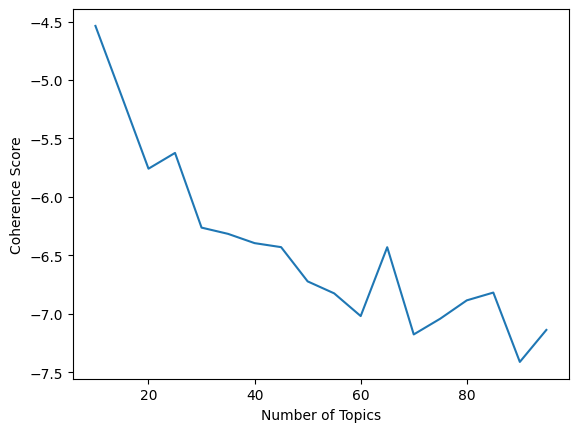

In [38]:
# plot the graph, and look for the elbow

import matplotlib.pyplot as plt
logging.getLogger('matplotlib').setLevel(logging.WARNING) # turn off logging for matplotlib too

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

The 'elbow' where the increase/decrease starts leveling off is usually taken as the sweet spot for determining the number of topics to assign. For UMass, the lower the number, the better the coherence. The elbow seems to be at around 90 topics. Let's re-run the model with 90 topics, and see whether the topics uncovered make sense.

In [39]:
num_topics = 85
chunksize = 500
passes = 10
iterations = 20
update_every = 1
eval_every = 5
random_state = 42

lda_model = gensim.models.ldamodel.LdaModel(
    corpus = corpus,
    id2word = id2word,
    num_topics = num_topics, 
    random_state = random_state,
    update_every = update_every,
    eval_every = eval_every,
    chunksize = chunksize,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    per_word_topics=True)

For further reading on how to estimate the number of topics, this blog is quite useful: https://www.meganstodel.com/posts/callbacks/ 

In [40]:
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
58    -0.123338 -0.098566       1        1  3.248732
24     0.200789  0.021744       2        1  2.460273
84    -0.177549 -0.047583       3        1  2.051296
30     0.056701 -0.156224       4        1  2.030658
61    -0.088227 -0.020585       5        1  1.963538
...         ...       ...     ...      ...       ...
62     0.042568 -0.078620      81        1  0.562524
25    -0.083882 -0.029470      82        1  0.446207
74    -0.080411  0.032470      83        1  0.409349
34     0.061328  0.010210      84        1  0.305320
70     0.005482  0.010228      85        1  0.238933

[85 rows x 5 columns], topic_info=         Term        Freq       Total Category  logprob  loglift
264      cell  520.000000  520.000000  Default  30.0000  30.0000
847   protein  267.000000  267.000000  Default  29.0000  29.0000
66      month  173.000000  173.000000  Default  28.0000  28.0000
267       day  214.000000  214.000000  Default  27.0000  27.0000
106     mouse  177.000000  177.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
71    perform    2.296326  141.548518  Topic85  -4.3419   1.9154
572     cause    1.880411  116.502463  Topic85  -4.5417   1.9103
145      test    1.755206  203.060973  Topic85  -4.6106   1.2858
865      need    1.433589   75.704893  Topic85  -4.8130   2.0701
265  clinical    1.329023  166.261197  Topic85  -4.8887   1.2076

[4134 rows x 6 columns], token_table=      Topic      Freq Term
term                      
529       1  0.059401   ''
529       3  0.014850   ''
529       5  0.207902   ''
529       9  0.059401   ''
529      12  0.044550   ''
...     ...       ...  ...
1001      6  0.195818  ±_±
1001     53  0.293727  ±_±
1551     19  0.071128   ìm
1551     37  0.497894   ìm
1551     38  0.355639   ìm

[16459 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[59, 25, 85, 31, 62, 16, 30, 22, 2, 8, 33, 79, 73, 3, 64, 81, 42, 82, 24, 13, 4, 45, 76, 19, 51, 23, 48, 53, 10, 11, 47, 66, 5, 38, 44, 1, 21, 6, 39, 72, 50, 74, 77, 37, 80, 17, 36, 46, 7, 27, 68, 84, 12, 18, 34, 40, 32, 69, 61, 55, 83, 28, 65, 9, 56, 57, 58, 52, 15, 60, 70, 78, 20, 67, 14, 41, 49, 54, 29, 43, 63, 26, 75, 35, 71])

### Recap

In this notebook, we learnt the following:
1. Text preprocessing and normalization.
2. Text augmentation by creating n-grams.
3. Compiling a corpus and dictionary for training.
4. Training a gensim LDA model and monitoring for training convergence.
5. Visualizing the model, and
6. Evaluating the model using coherence.

In our next notebook, we'll use a language model to perform topic modelling on this dataset, and we can compare the 2 methods.